<a href="https://colab.research.google.com/github/Martinexe4/Raid-defect-Flaking_Spalling-and-Squate/blob/main/Rail_Defect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/Railway_Defect_Project/Dataset/Fix_Data

Rail_data


In [ ]:
dataset_path = '/content/drive/MyDrive/Railway_Defect_Project/Dataset/Fix_Data/Rail_data'

# Category names
categories = ['Flaking_Spalling','Squate']

# Output folder path
output_path = './Dataset/Processed_Data'

In [ ]:
# Create output folders
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create sub-folders for training, validation, and testing
for split in ['train', 'val']:
    split_path = os.path.join(output_path, split)
    if not os.path.exists(split_path):
        os.makedirs(split_path)
    for category in categories:
        category_path = os.path.join(split_path, category)
        if not os.path.exists(category_path):
            os.makedirs(category_path)

# Function to split the dataset
def split_dataset(category):
    category_path = os.path.join(dataset_path, category)
    images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    train_images, val_images = train_test_split(images, test_size=0.3, random_state=42)

    return train_images, val_images

# Move files to appropriate folders
def move_files(images, category, split):
    for image in images:
        src = os.path.join(dataset_path, category, image)
        dst = os.path.join(output_path, split, category, image)
        shutil.copy2(src, dst)

# Split the dataset and move files
for category in categories:
    train_images, val_images = split_dataset(category)
    move_files(train_images, category, 'train')
    move_files(val_images, category, 'val')

print("Dataset splitting finished.")

Dataset splitting finished.


In [ ]:

# Count images in each category and split
for category in categories:
    for split in ['train', 'val']:
        split_path = os.path.join(output_path, split, category)
        num_images = len(os.listdir(split_path))
        print(f"Number of {category} images in {split}: {num_images}")


Number of Flaking_Spalling images in train: 42
Number of Flaking_Spalling images in val: 19
Number of Squate images in train: 58
Number of Squate images in val: 26


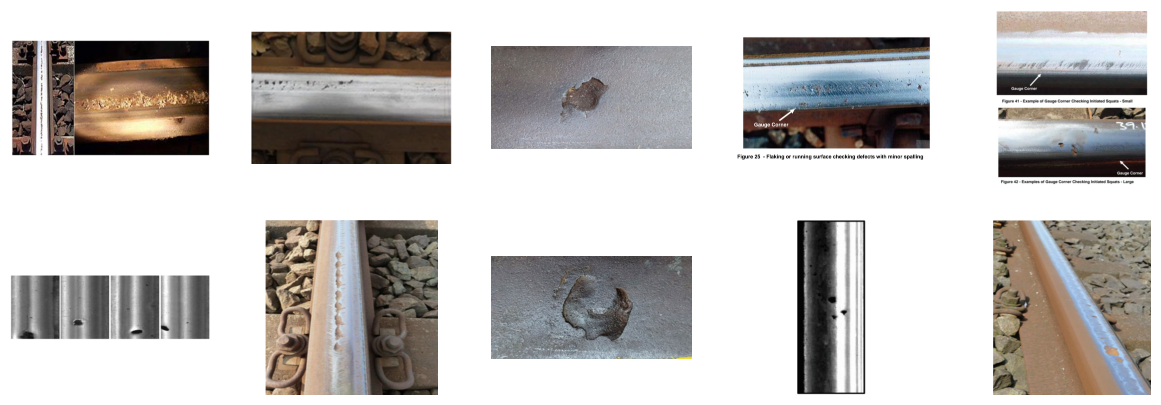

In [ ]:
train_flaking_path = './Dataset/Processed_Data/train/Flaking_Spalling'
flaking_images = [f for f in os.listdir(train_flaking_path) if os.path.isfile(os.path.join(train_flaking_path, f))]

plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = mpimg.imread(os.path.join(train_flaking_path, flaking_images[i]))
    plt.imshow(img)
    plt.axis('off')
plt.show()


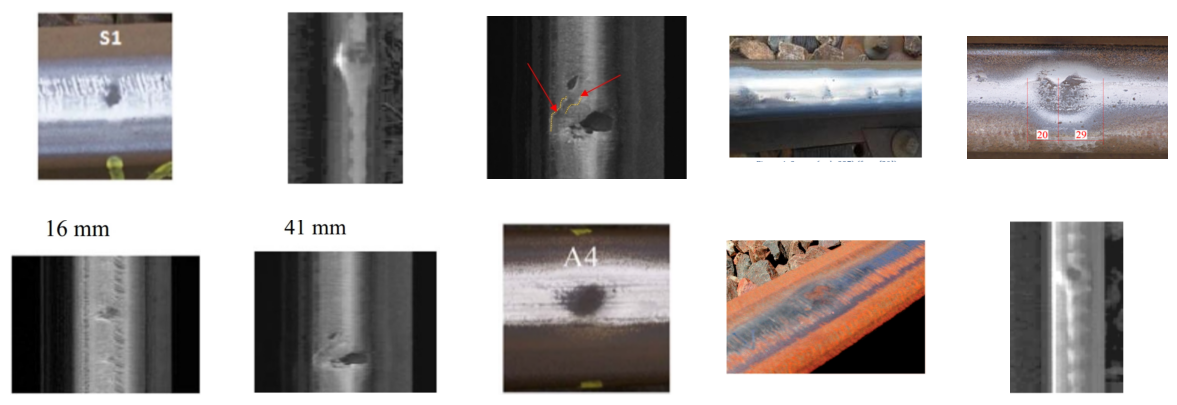

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_squate_path = './Dataset/Processed_Data/train/Squate'
squate_images = [f for f in os.listdir(train_squate_path) if os.path.isfile(os.path.join(train_squate_path, f))]

plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = mpimg.imread(os.path.join(train_squate_path, squate_images[i]))
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:

# Load model pretrained VGG16
base_model = tf.keras.applications.VGG16(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Membekukan layer awal

# Membuat model dengan base model VGG16 dan menambahkan layer di atasnya
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])



58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 18910017 (72.14 MB)
Trainable params: 4195329 (16.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
#train datagen
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data augmentation untuk validation set
validation_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    './Dataset/Processed_Data/train',
    batch_size=10,
    class_mode='binary',
    target_size=(150, 150)
)

validation_generator = validation_datagen.flow_from_directory(
    './Dataset/Processed_Data/val',
    batch_size=10,
    class_mode='binary',
    target_size=(150, 150)
)


Found 100 images belonging to 2 classes.
Found 45 images belonging to 2 classes.


In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


In [ ]:
# Training model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/50
10/10 [==============================] - 15s 751ms/step - loss: 2.7472 - accuracy: 0.5400 - val_loss: 1.6554 - val_accuracy: 0.5778


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
10/10 [==============================] - 7s 737ms/step - loss: 1.5120 - accuracy: 0.5800 - val_loss: 1.1470 - val_accuracy: 0.5111
Epoch 3/50
10/10 [==============================] - 8s 789ms/step - loss: 1.0185 - accuracy: 0.7100 - val_loss: 1.0908 - val_accuracy: 0.5556
Epoch 4/50
10/10 [==============================] - 7s 683ms/step - loss: 1.0775 - accuracy: 0.7100 - val_loss: 1.2759 - val_accuracy: 0.6000
Epoch 5/50
10/10 [==============================] - 6s 648ms/step - loss: 1.1120 - accuracy: 0.6500 - val_loss: 1.2260 - val_accuracy: 0.6889
Epoch 6/50
10/10 [==============================] - 8s 796ms/step - loss: 0.8719 - accuracy: 0.7500 - val_loss: 1.1037 - val_accuracy: 0.5778
Epoch 7/50
10/10 [==============================] - 6s 653ms/step - loss: 0.8554 - accuracy: 0.7400 - val_loss: 1.1241 - val_accuracy: 0.6444
Epoch 8/50
10/10 [==============================] - 7s 766ms/step - loss: 0.7991 - accuracy: 0.7800 - val_loss: 1.0919 - val_accuracy: 0.6444
Epoch 

In [ ]:
model.evaluate(train_generator)

10/10 [==============================] - 5s 517ms/step - loss: 0.3615 - accuracy: 0.9300


[0.36147940158843994, 0.9300000071525574]

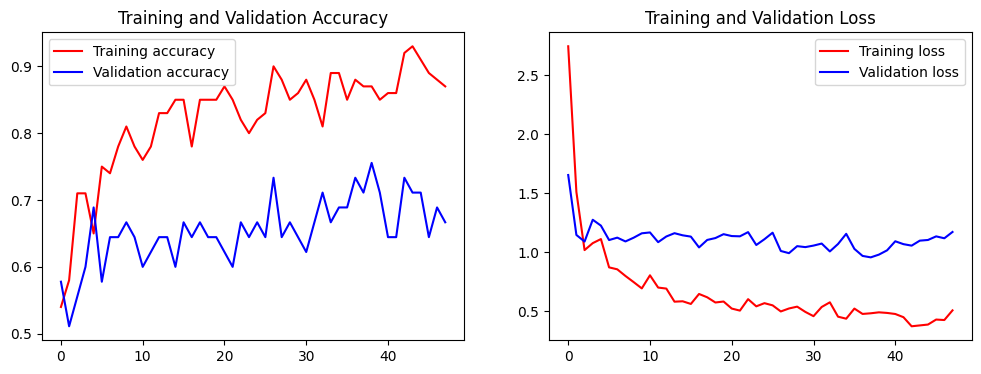

In [ ]:
# Visualisasi hasil pelatihan
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 4))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a squate")
  else:
    print(fn + " is a flaking and spalling")


Saving Picture158.png to Picture158.png
1/1 [==============================] - 1s 1s/step
[0.99998176]
Picture158.png is a squate
